In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *

# 1. Download the sample IMDB data


In [0]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

# 2. Check the data


In [0]:
df = pd.read_csv(path/'texts.csv')
df.head(2)

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False


In [0]:
df['text'][0]

"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!"

# 3. Create language **model**

In [0]:
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')
data_lm.save()
data_lm = load_data(path)

In [0]:
data_lm.show_batch(2)

idx,text
0,"of an xxup xxunk victim is strong , perhaps even overdone at times ( sometimes her dialog dissolves into xxunk xxunk ) . xxmaj but the overall effect is commendable and xxunk . xxmaj branagh may be the perfect compliment to her performance . \n \n xxbos a very realistic portrait of a broken family and the effect it has on the kid caught in between . xxmaj as"
1,"air her prejudices , grievances and general xxunk towards the xxmaj english . xxmaj the general sentiment of xxmaj indian superiority over the xxmaj english in this film is foul . \n \n xxmaj the xxmaj english people in this film are portrayed as overweight , violent , foul - mouthed , promiscuous , engaging in child neglect , stupid , uneducated , racist , ugly , eating poor"


In [0]:
type(data_lm.vocab)

fastai.text.transform.Vocab

In [0]:
data_lm.vocab.itos[10:15]

['.', ',', 'and', 'a', 'of']

In [0]:
[x for x in data_lm.vocab.stoi.items()][10:15]

[('.', 10), (',', 11), ('and', 12), ('a', 13), ('of', 14)]

In [0]:
data_lm.train_ds[0][0].text[:40]

'xxbos i had my doubts about another love'

In [0]:
data_lm.train_ds[0][0].data[:10]

array([   2,   19,   79,   80, 3762,   58,  193,  140,   85, 4641])

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
type(learn)

fastai.text.learner.LanguageLearner

In [56]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(8840, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(8840, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=8840, bias=True)
    (output_dp): RNNDropout()
  )
)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


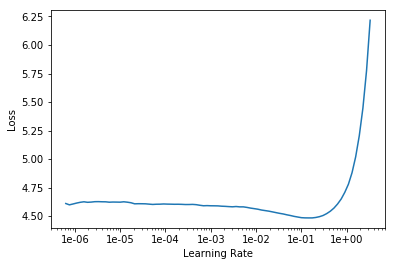

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.391911,3.955667,0.282664,00:11


In [0]:
learn.save("lm-1")
learn.load("lm-1");

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.175117,3.908213,0.282917,00:14


In [0]:
learn.save("lm-2")
learn.load("lm-2");

In [0]:
learn.save_encoder("lm-2-enc")

In [0]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because it was great . It was a great film , really good . It 's a very funny movie , it is almost the only film that is much better for my fans and TV .
I liked this movie because i started watching it sometime in the early 1980s . It 's a bit of a sci - fi thriller , and i have never seen it in any else Luis Guzman movie since . It


# 4. Create the classifier model

In [0]:
data = TextClasDataBunch.from_csv(path, "texts.csv", vocab=data_lm.vocab)

In [61]:
[x for x in data.vocab.stoi.items()][10:15]

[('.', 10), (',', 11), ('and', 12), ('a', 13), ('of', 14)]

In [0]:
learn = text_classifier_learner(data, AWD_LSTM, drop_mult=0.5)

In [63]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(8840, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(8840, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.

In [0]:
learn.load_encoder("lm-2-enc")

In [67]:
learn.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(8840, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(8840, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


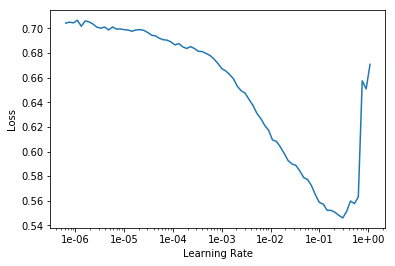

In [68]:
learn.recorder.plot()

In [69]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.548455,0.650899,0.537313,00:09


In [70]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.440366,0.577071,0.761194,00:09


In [0]:
learn.save("cm-1")
learn.load("cm-1");

In [74]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn.save("cm-2")
learn.load("cm-2");

epoch,train_loss,valid_loss,accuracy,time
0,0.419900,0.525431,0.781095,00:10


In [75]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.save("cm-3")
learn.load("cm-3");

epoch,train_loss,valid_loss,accuracy,time
0,0.376359,0.450707,0.805970,00:14


In [77]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.save("cm-4")
learn.load("cm-4");

epoch,train_loss,valid_loss,accuracy,time
0,0.296571,0.370454,0.830846,00:18
1,0.278215,0.367668,0.830846,00:19


In [84]:
learn.predict("That movie is not great")

(Category negative, tensor(0), tensor([0.6569, 0.3431]))